In [1]:
using Revise

In [3]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1664


In [4]:
using PotentialFlow

In [5]:
using CairoMakie
#using Plots
#pyplot()

In [6]:
using LaTeXStrings

In [7]:
using Distributions
using Random
using LinearAlgebra
using GaussianMixtures
using Statistics

### Truth

In [8]:
t = 0.0
δ_true = 0.1


#=
# For placing the vortices randomly
=#
#=
Nv_cluster = 5
Nv_per_cluster = 1
Nv_true = Nv_cluster*Nv_per_cluster 

xr = (-1.5,1.5)
yr = (-1.0,1.0)
Γr = (-2.0,2.0)

σx = 0.03
σΓ = 0.03
zv, Γv = createclusters(Nv_cluster,Nv_per_cluster,xr,yr,Γr,σx,σΓ,each_cluster_radius=1.5*σx)
=#

#=
Prescribed placement
=#
#zv = [0.5+1.0im]
#Γv = [1.0]
zv = [-1.0+1.25im,0.75+1.0im]  # [-1.0+0.75im,0.75+0.5im]
Γv = [1.2,-1.0]
#zv = [-1.0+0.75im,0.25+0.5im,0.75+0.75im]
#Γv = [1.0,-1.2,1.4]
Nv_true = length(zv);

#=
x_true = [-0.7611581857580003,
  0.7266716391085539,
  0.04730897238217636,
  0.4637373841856715,
  0.6347931827658125,
  1.6466841098688845];
  zv, Γv = state_to_positions_and_strengths(x_true)
  Nv_true =  length(zv)
=#


### Create sensors

In [47]:
# sensors on a grid
#=
xmin, xmax = -2.5, 2.5
xsens = range(xmin,xmax,length=81)
ysens = range(xmin,xmax,length=81)
zsens = xsens .+ im*ysens';
sens = vec(zsens);
=#

# sensors in a circle
rsens = 2.0
Nsens = 21
θsens = range(0,2π,length=Nsens+1)
#sens = rsens*exp.(im*θsens[1:end-1]);

# sensors in lines
Nsens = 9
ϵsens = 0.0
lowerrow = range(-2.0,2.0,length=Nsens) .+ (-0.5ϵsens .+ ϵsens*rand(Nsens))*im
#upperrow = range(-2.0,2.0,length=Nsens) .+ 1.0*im
#leftside = im*range(-1.0,3.0,length=Nsens) .- 1.0
#rightside = im*range(-1.0,3.0,length=Nsens) .+ 1.0
sens = vcat(lowerrow,);  #upperrow);

### Set some plotting themes

In [75]:
xytheme = Theme(
        Axis = (aspect=DataAspect(),xlabel=L"x",ylabel=L"y"),
        palette = (color = Makie.wong_colors(),),
        Lines = (cycle = [:color],),
        Scatter = (cycle = [:color],)
    );

sensortheme = Theme(
    Axis = (xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty")
);

#### Set up the observer for the truth data

In [76]:
config_true = VortexConfig(Nv_true, δ_true, body=LowRankVortex.NoWall)

truez = zv

vort = Vortex.Blob.(zv,Γv,δ_true)
x_true = lagrange_to_state(vort,config_true)

obs_true = PressureObservations(sens,config_true);

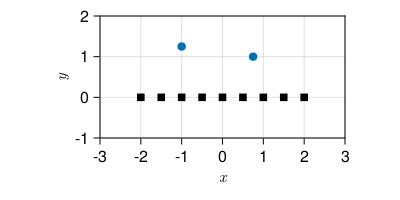

In [77]:
with_theme(xytheme) do
    f = Figure(;resolution = (400, 200))
    ax = f[1,1] = Axis(f;limits=(-3,3,-1,2))
    show_vortices!(ax,x_true,obs_true)
    plot_sensors!(ax,obs_true)
    f
end

### Evaluate the true sensor data and add noise

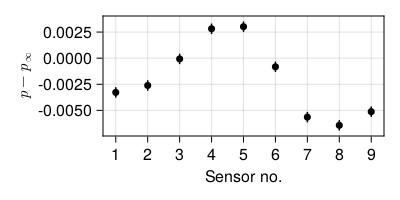

In [80]:
# evaluate data without noise
ystar0 = observations(x_true,t,obs_true);

# set measurement noise level
ϵmeas_data = [2.5e-4,3.75e-4,5e-4,6.25e-4,8e-4,1e-3,1.5e-3,2e-3,3e-3,4e-3];
ϵmeas = ϵmeas_data[3] #5e-4 #1e-3

Σϵ = Diagonal(ϵmeas^2*ones(length(sens)))

noisedist = MvNormal(zero(ystar0),Σϵ)
ystar = ystar0 #+ rand(noisedist)

with_theme(sensortheme) do
    f = Figure(;resolution = (400, 200))
    ax = f[1,1] = Axis(f)
    plot_sensor_data!(ax,ystar0,obs_true;sensor_noise=ϵmeas*ones(length(ystar)))
    f
end

## Vortex estimation

In [83]:
Nv_estimator = 2
δ = 0.1

config_estimator = VortexConfig(Nv_estimator, δ, body=LowRankVortex.NoWall)


# ranges to confine the prior mean to
xr = (-2,2)
yr = (0.01,2) #(0.01,2.0)
Γr = (-2,2)
Γtotr = (0.01,2)
bounds = create_state_bounds(xr,yr,Γr,config_estimator;Γtotr=Γtotr);


obs = PressureObservations(sens,config_estimator);

# Function for the log of the joint distribution
function my_logp̃(x::Vector)
    logp̃ = normal_loglikelihood(x,t,ystar,Σϵ,obs)
    logp̃ += log_uniform(x,bounds)
end

my_logp̃ (generic function with 1 method)

### MCMC approach

In [84]:
## Parallel tempering ##
# Set the number of chains and the inverse "temperature" of each chain
nchain = 5
β = 5.0.^(range(0,-3,length=nchain));

In [89]:
Ntrial = 10000
propvarX = 0.01^2 # 0.01^2
propvarY = 0.01^2 # 0.01^2
propvarΓ = 0.01^2 # 0.01^2
propvar = state_covariance(propvarX,propvarY,propvarΓ,config_estimator);

# scale the covariance of each chain by its temperature
propvars = [propvar/β[i] for i = 1:nchain];

In [86]:
#xseed = copy(x_true)
xseed = generate_random_state(xr,yr,Γr,obs.config)
xseeds = [xseed for n = 1:nchain]
#xseeds = [generate_random_state(xr,yr,Γr,obs.config) for n = 1:nchain]

x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,my_logp̃,propvars;β=β,process_state=x->state_filter!(x,obs));

In [87]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [88]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

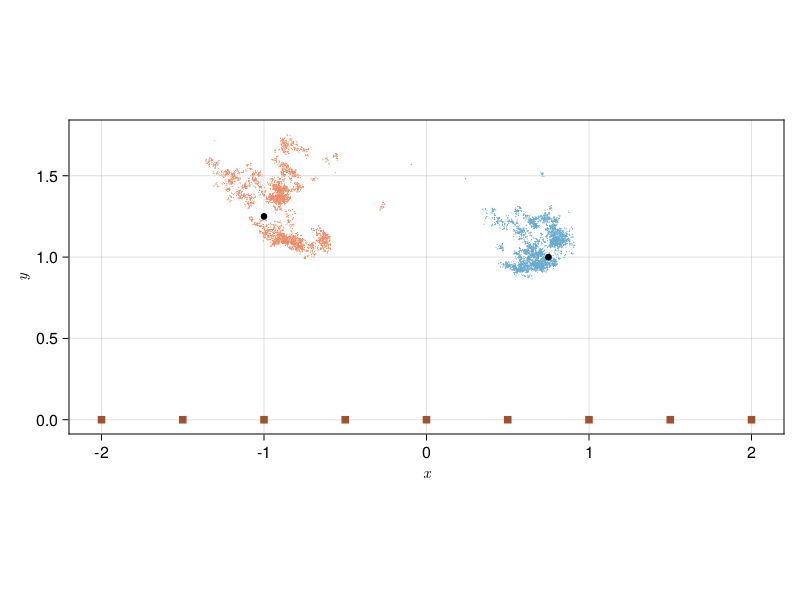

In [59]:
with_theme(xytheme) do
    f = Figure()
    ax = f[1,1] = Axis(f)
    show_vortex_samples!(ax,x_data[1],obs,nskip=1,colormap=:RdBu_3)
    scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=8,color=:black,strokewidth=1)
    plot_sensors!(ax,obs,color=:sienna)
    f
end

#### Build from the first chain 

In [60]:
#β = 2.0.^(range(0,-3,length=nchain));

In [61]:
Ntrial = 600000
propvarX = 0.005^2 # 0.01^2
propvarY = 0.005^2 # 0.01^2
propvarΓ = 0.005^2 # 0.01^2
propvar = state_covariance(propvarX,propvarY,propvarΓ,config_estimator);

propvars = [propvar/β[i] for i = 1:nchain];

In [62]:
xseeds = [x_data[j][:,end] for j = 1:nchain]
x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,my_logp̃,propvars;β=β,process_state=x->state_filter!(x,obs));

In [63]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.7779540734864218
 0.7749074169752768
 0.7926340245532515
 0.8239439201869327
 0.8166639444535185

In [64]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.06775071383567703
 0.056975505857294995
 0.05537519957424162
 0.12335769338285213

#### Only save every  `nskip`th sample to remove data correlations

In [65]:
nskip = 100
x_decorr_data = x_data[1][:,1:nskip:end];

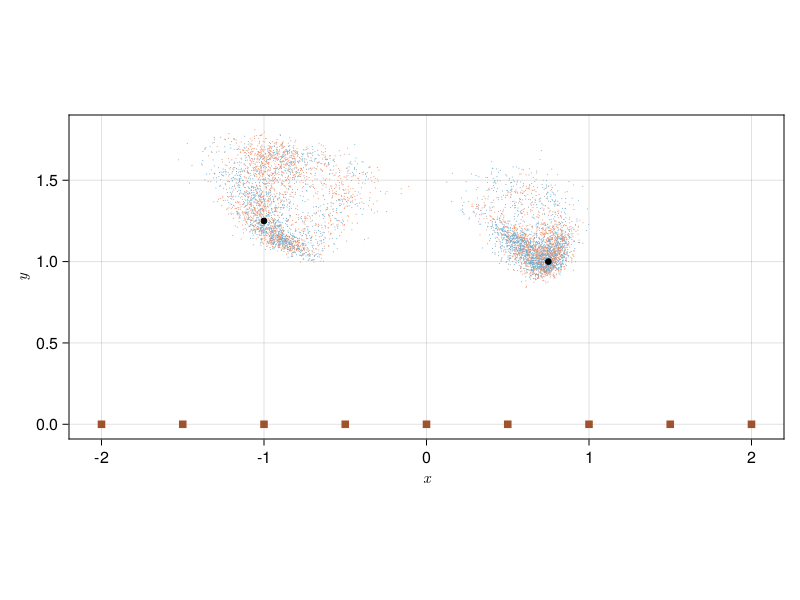

In [66]:
with_theme(xytheme) do
    f = Figure()
    ax = f[1,1] = Axis(f)
    show_vortex_samples!(ax,x_decorr_data,obs,colormap=:RdBu_3)
    scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=8,color=:black,strokewidth=1)
    plot_sensors!(ax,obs,color=:sienna)
    f
end

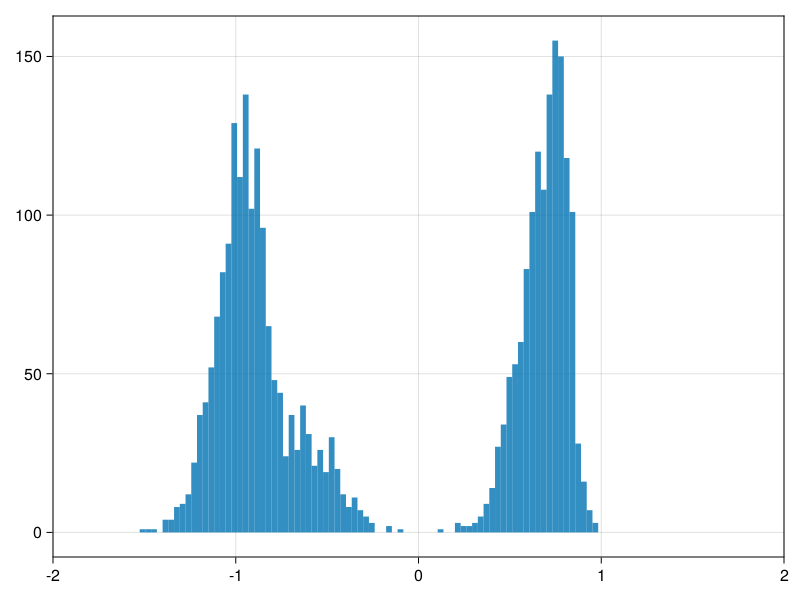

In [67]:
data_histogram(x_decorr_data[1,:])

In [68]:
gm = classify_by_gmm(9,x_decorr_data);

K-means converged with 15 iterations (objv = 460.2029129911978)


┌ Info: Initializing GMM, 9 Gaussians diag covariance 6 dimensions using 3001 data points
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:79
┌ Info: K-means with 3001 data points using 15 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:141


In [69]:
weights(gm)

9-element Vector{Float64}:
 0.254915028323892
 0.0610968113670249
 0.10358481264488681
 0.09713794971000876
 0.16817676085785283
 0.09107015683624917
 0.07004471253549885
 0.03674936041360601
 0.11722440731098066

In [71]:
alpha_threshold = 0.9 # 0.9
gmj = gm

best_comp = 

# take only the top `alpha_threshold` percent
maxw = maximum(weights(gmj))
idx = weights(gmj).>= alpha_threshold*maxw
wts = weights(gmj)[idx]./sum(weights(gmj)[idx])
_, best_comp = findmax(wts)

Σ = covars(gmj)[idx,:]
Σ_0 = state_covariance(δ^2,δ^2,0.0,config_estimator);
Σ = [Σ[j] .+ Σ_0 for j = 1:length(Σ)] # add the blob size to the covariance
xm = transpose(means(gmj)[idx,:])

6×1 transpose(::Matrix{Float64}) with eltype Float64:
 -0.9427555765087948
  1.3860213973958968
  1.3869251952214086
  0.6793628910063075
  1.0674365100388634
 -0.9544182164079499

#### Contruct the filename descriptor

In [72]:
ds_string = string(1000+round(Int,100*abs(obs.sens[end]-obs.sens[1])/(length(obs.sens)-1)))[2:end]
ns_string = string(length(obs.sens))
nv_string = string(obs.config.Nv)
alpha_string = string(round(Int,100+100*alpha_threshold))[2:3]

filename = nv_string*"vortex-2truthpm-"*ns_string*"sensor-ds"*ds_string*"-top"*alpha_string*"-noise5em4"

"2vortex-2truthpm-9sensor-ds050-top90-noise5em4"

In [73]:
#plottype = :samples
plottype = :vorticity

saveplot = false

false

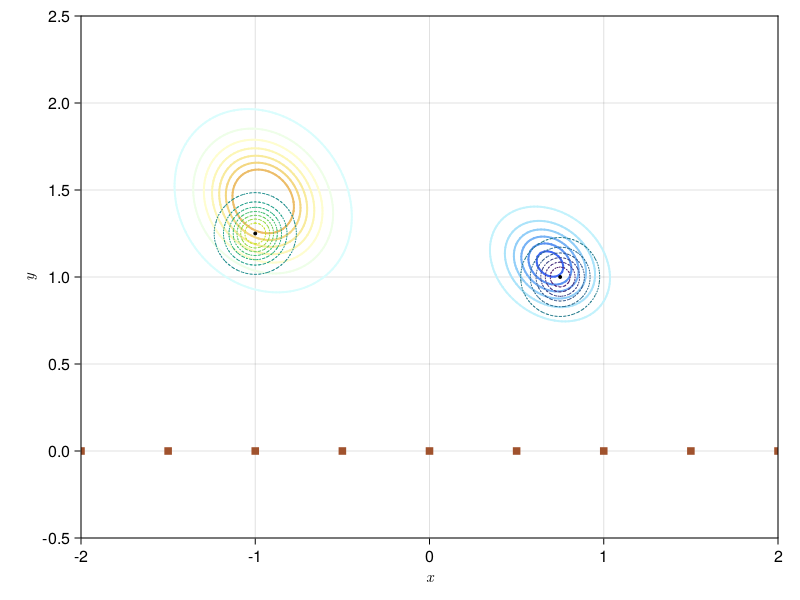

In [74]:
with_theme(xytheme) do
    f = Figure()
    ax = f[1,1] = Axis(f)

    if plottype == :samples
        show_vortex_samples!(ax,x_decorr_data,obs,colormap=:RdBu_3)
        #vortex_ellipses!(ax,xm[:,best_comp],Σ[best_comp],obs,color=:red)
        vortex_ellipses!(ax,xm,Σ,wts,obs)
    
    elseif plottype == :vorticity
        lev = range(-1,1,length=14)
        plot_vorticity!(ax,xm,Σ,wts,obs,xlims=(-2,2),ylims=(-1,2.5),colormap=:lighttemperaturemap,linewidth=2,levels=lev)
        #plot_vorticity!(ax,xm[:,best_comp],Σ[best_comp],obs,ylims=(-1,2.5),colormap=:lighttemperaturemap,linewidth=2,levels=range(-1,1,length=14))

        Σ_true = state_covariance(δ_true^2,δ_true^2,0.0,config_true);
        plot_vorticity!(ax,x_true,Σ_true,obs_true,ylims=(-1,2),linestyle=:dot,linewidth=1,levels=lev)
    end

    scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=4,color=:black,strokewidth=1)
    plot_sensors!(ax,obs,color=:sienna)
    ylims!(ax,(-0.5,2.5))
    xlims!(ax,(-2,2))
    
    fullname = String(plottype)*"-"*filename*".pdf" 
    saveplot && save(fullname,f)
    f
end

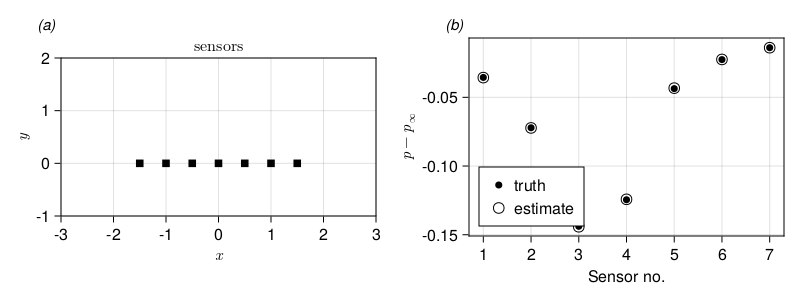

In [2943]:
best_comp = 1

f = Figure(;resolution=(800,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()

axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-3,3,-1,2),aspect=DataAspect(),title=L"\textrm{sensors}")
plot_sensors!(axleft,obs)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty")
plot_sensor_data!(axcenter,ystar,xm[:,best_comp],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))
axislegend(axcenter,position=:lb)


for (label, layout) in zip(["(a)", "(b)"], [ga, gb])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("basicdata-1vortex-3sensor.pdf",f)

f

#### Plotting the pressure

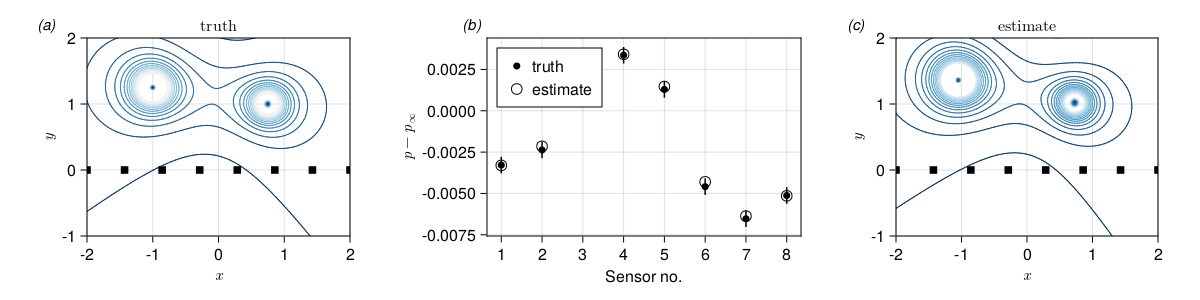

In [290]:
l = range(-0.5,0.01,length=21)
cl = (-0.5,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)
plot_pressure_field!(axleft,x_true,obs_true,levels=range(-0.25,0,length=15))
plot_pressure_field!(axright,xm[:,best_comp],obs,levels=range(-0.25,0,length=15),mode=:relative)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty") 
plot_sensor_data!(axcenter,ystar,xm[:,best_comp],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))
axislegend(axcenter,position=:lt)


for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("pressure-"*filename*".pdf",f)

f